##Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Inception Model

###Load Dataset
torchvision 패키지에서 제공하는 STL-10 

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '/data'

if  not os.path.exists(path2data):
  os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)
valid_ds = datasets.STL10(path2data, split='test', download='True', transform=data_transformer)

print(train_ds.data.shape)
print(valid_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


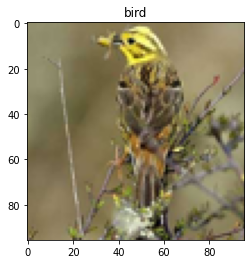

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

check_img = np.transpose(train_ds.data[0], (1,2,0))
plt.title(train_ds.classes[train_ds.labels[0]])
plt.imshow(check_img)

###Normalize transformation

In [ ]:
# normalize transformation을 적용하기 위해 평균, 표준편차 계산
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [ ]:
# transformation 객체 생성
from torch.utils.data import DataLoader

train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
valid_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

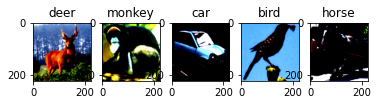

In [ ]:
# check_img = np.transpose(train_ds.data[0], (1,2,0))
# plt.title(train_ds.classes[train_ds.labels[0]])
# plt.imshow(check_img)

# check_img2 = np.transpose(train_dl.dataset[0][0], (1,2,0))
# plt.imshow(check_img2)

for i in range(5):
  plt.subplot(1,5, i + 1)
  img, l = next(iter(train_dl))
  dp_img = np.transpose(img[i], (1,2,0))
  plt.title(train_ds.classes[l[i]])
  plt.imshow(dp_img)


### 모델 구축

컨볼루션 블록 : 컨볼루션 연산 -> 배치 정규화 -> ReLU 활성화 함수 적용

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)

인셉션 블록 : 1 X 1, 3 X 3, 5 X 5 컨볼루션 연산과 풀링 연산 진행

In [ ]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 각 branch의 출력값을 묶어줌 torch.cat : 텐서 쌓기 함수 - 주어진 차원 내에서
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1) # 채널 방향으로 합친다
        return x

In [ ]:
# auxiliary classifier의 loss는 0.3이 곱해지고, 최종 loss에 추가. 정규화 효과 
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [ ]:
class GoogLeNet(nn.Module):
  def __init__(self, aux_logits=True, num_classes=10, init_weights=True):
    super(GoogLeNet, self).__init__()
    assert aux_logits == True or aux_logits == False
    self.aux_logits = aux_logits

    self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(3, 2, 1)
    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(3, 2, 1)
    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(3, 2, 1)
    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

    # auxiliary classifier

    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

    # auxiliary classifier

    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(3, 2, 1)
    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

    self.avgpool = nn.AvgPool2d(7, 1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

    if self.aux_logits:
        self.aux1 = InceptionAux(512, num_classes)
        self.aux2 = InceptionAux(528, num_classes)
    else:
        self.aux1 = self.aux2 = None

    # weight initialization
    if init_weights:
        self._initialize_weights()

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)

    if self.aux_logits and self.training:
        aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux_logits and self.training:
        aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)

    x = x.view(x.shape[0], -1)

    x = self.dropout(x)
    x = self.fc1(x)
    
    if self.aux_logits and self.training:
        return x, aux1, aux2
    else:
        return x 

  # define weight initialization function
  def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
          if m.bias is not None:
            nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
          elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)
  

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GoogLeNet(aux_logits=False, num_classes=10, init_weights=True).to(device)

# 개수, 차원, 세로, 가로
x = torch.randn(3, 3, 224, 224).to(device)
output = model(x)
print(output)
print(model)

cuda
tensor([[ 0.0633, -0.2983, -0.0824, -0.1436, -0.1287, -0.3314,  0.0767, -0.1659,
          0.0208, -0.0373],
        [-0.0357,  0.3023,  0.4958, -0.0318, -0.2053, -0.6248,  0.0514, -0.4865,
          0.3075, -0.3974],
        [ 0.2401,  0.3299,  0.2339, -0.3564, -0.1132, -0.1119,  0.2077, -0.4955,
          0.0526,  0.2431]], device='cuda:0', grad_fn=<AddmmBackward0>)
GoogLeNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): conv_block(
    (conv_layer): Sequential(
      (0): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): Inception_block(
    (branch1): conv_block(
      (conv_layer): Sequential(
        (0): Co

### Train Model

In [ ]:
from torch.optim.lr_scheduler import StepLR

loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = StepLR(opt, step_size=10, gamma=0.1)

# hyper parameters
num_epochs = 20
optimizer = opt
loss_func = loss_func
train_dl = train_dl
val_dl = valid_dl
sanity_check = False
lr_scheduler = lr_scheduler
path2weights = '/content/drive/MyDrive/Colab_Notebooks/pytorch/code/implementation/models/inception_weights.pt'

In [ ]:
import copy

loss_history = {'train': [], 'val': []}
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
  model.train()

  running_loss = 0.0
  len_data = len(train_dl.dataset)

  for xb, yb in train_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b = loss_func(output, yb)
    opt.zero_grad()
    loss_b.backward()
    opt.step()

    running_loss += loss_b
    
  loss = running_loss / len_data
  loss_history['train'].append(loss)

  model.eval()
  with torch.no_grad():
    val_running_loss = 0.0
    for xb, yb in valid_dl:
      xb = xb.to(device)
      yb = yb.to(device)
      output = model(xb)

      loss_val = loss_func(output, yb)
      val_running_loss += loss_val
    val_loss = val_running_loss / len(valid_dl.dataset)
  
  if val_loss < best_loss:
    best_loss = best_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), path2weights)
    print('copied best model weights')
  loss_history['val'].append(val_loss)
  lr_scheduler.step()

print(loss)
model.load_state_dict(best_model_wts)

copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
tensor(0.0748, device='cuda:0', grad_fn=<DivBackward0>)


<All keys matched successfully>

real label :  cat


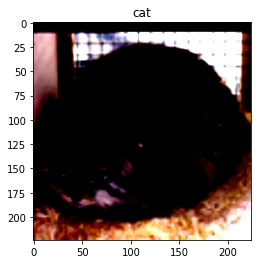

In [ ]:
img, label = next(iter(valid_dl))
inference_img = img[0]
real_label = train_ds.classes[label[0]]
print("real label : ", real_label)

x = torch.randn(1, 3, 224, 224).to(device)
x[0] = inference_img
inference_out = model(x)
# print(inference_out)
best_index = inference_out.max(dim=1).indices.item()
plt.title(train_ds.classes[best_index])
plt.imshow(np.transpose(inference_img, (1,2,0)))

RuntimeError: ignored

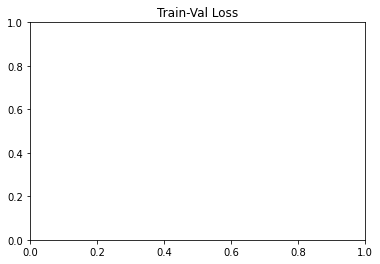

In [ ]:
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_history["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_history["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()